# Group Assignment 1.7: Distribution Fitting

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 7, Friday Oct 18, 2024.*

## Case 1: Wave impacts on a crest wall

**What's the propagated uncertainty? *How large will be the horizontal force?***

In this project, you have chosen to work on the uncertainty of wave periods and wave heights in the Alboran sea to estimate the impacts on a crest wall: a concrete element installed on top of mound breakwater. You have observations from buoys of the significant wave height ($H$) and the peak wave period ($T$) each hour for several years. As you know, $H$ and $T$ are hydrodynamic variables relevant to estimate wave impacts on the structure. The maximum horizontal force (exceeded by 0.1% of incoming waves) can be estimated using the following equation (USACE, 2002).

$$
F_h = \left( A_1 + A_2 \frac{H}{A_c} \right) \rho g C_h L_{0p}
$$

where $A_1=-0.016$ and $A_2=0.025$ are coefficients that depend on the geometry of the structure, $A_c=3m$ is the elevation of the frontal berm of the structure, $\rho$ is the density of water, $g$ is the gravity acceleration, $C_h=2m$ is the crown wall height, and $L_{0p}=\frac{gT^2}{2\pi}$ is the wave length in deep waves. Thus, the previous equation is reduced to

$$
F_h = 255.4 H T^2 -490.4 T^2
$$

**The goal of this project is:**
1. Choose a reasonable distribution function for $H$ and $T$.
2. Fit the chosen distributions to the observations of $H$ and $T$.
3. Assuming $H$ and $d$ are independent, propagate their distributions to obtain the distribution of $F_h$.
4. Analyze the distribution of $F_h$.

## Importing packages

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats 
from math import ceil, trunc

plt.rcParams.update({'font.size': 14})

## 1. Explore the data

First step in the analysis is exploring the data, visually and through its statistics.

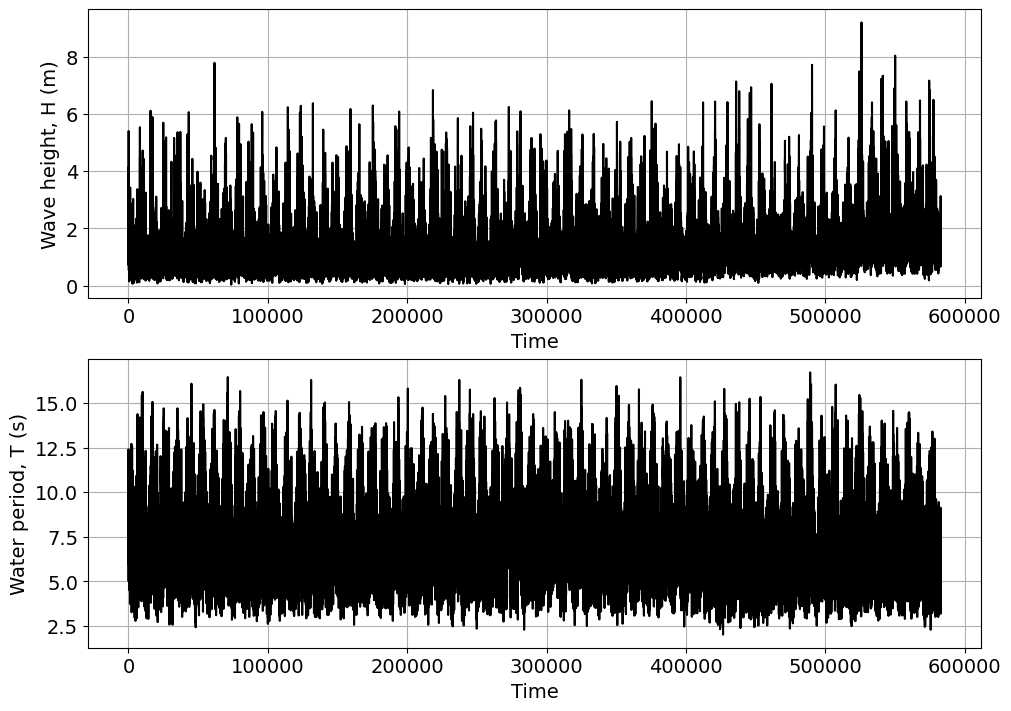

In [44]:
# Import
_, H, T = np.genfromtxt('dataset_HT.csv', delimiter=",", unpack=True, skip_header=True)

# plot time series
fig, ax = plt.subplots(2, 1, figsize=(10, 7), layout = 'constrained')
ax[0].plot(H,'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Wave height, H (m)')
ax[0].grid()

ax[1].plot(T,'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Water period, T (s)')
ax[1].grid()

In [45]:
# Statistics for H

print(stats.describe(H))

DescribeResult(nobs=582755, minmax=(0.04, 9.19), mean=1.296410395449203, variance=0.6644958817096485, skewness=1.7333548566943697, kurtosis=4.692941566067729)


In [46]:
# Statistics for d

print(stats.describe(T))

DescribeResult(nobs=582755, minmax=(2.02, 16.71), mean=6.861141165669963, variance=4.710342223823444, skewness=0.7832887838396299, kurtosis=0.17655975523967093)


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1:</b>   
Describe the data based on the previous statistics:
    <li>Which variable presents a higher variability?</li>
    <li>What does the skewness coefficient means? Which kind of distribution functions should we consider to fit them?</li>
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution 1:</b>
    <li>$T$ presents a higher variance but a much higher mean. Then, if we compute the coefficient of variation to standardize that variability, we obtain $CV(H)=0.664/1.296 = 0.512$ and $CV(T)= 4.710/6.861 = 0.686.3$. Thus, $T$ has higher variability than $H$.</li>
    <li>Both $H$ and $T$ has a positive non-zero skewness, being the one for $H$ significantly higher. Thus, the data presents a right tail and mode < median < mean. An appropriate distribution for $H$ and $T$ would be one which: (1) it is bounded in 0 (no negative values of $H$ or $T$ are physically possible), and (2) has a positive tail. If we consider the distributions that you have been introduced to, Lognormal, Gumbel or Exponential would be a possibility</li>
</div>
</div>

## 2. Empirical distribution functions

Now, we are going to compute and plot the empirical PDF and CDF for each variable. Note that you have the pseudo-code for the empirical CDF in the [reader](https://mude.citg.tudelft.nl/book/probability/empirical.html).

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2:</b>   
Define a function to compute the empirical CDF.
</p>
</div>

In [51]:
def ecdf(var):
    x = np.sort(var) # sort the values from small to large
    n = x.size # determine the number of datapoints\
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

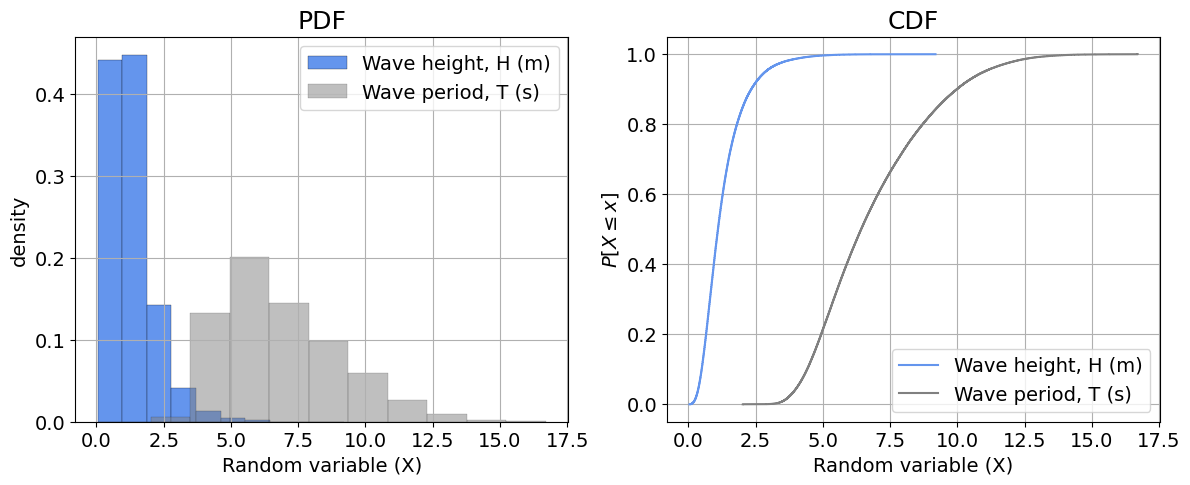

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(H, edgecolor='k', linewidth=0.2, 
             color='cornflowerblue', label='Wave height, H (m)', density = True)
axes[0].set_xlabel('Random variable (X)')
axes[0].set_ylabel('density')
axes[0].hist(T, edgecolor='k', linewidth=0.2, alpha = 0.5, 
             color='grey', label='Wave period, T (s)', density = True)
axes[0].set_title('PDF', fontsize=18)
axes[0].grid()
axes[0].legend()

axes[1].step(ecdf(H)[1], ecdf(H)[0], 
             color='cornflowerblue', label='Wave height, H (m)')
axes[1].set_xlabel('Random variable (X)')
axes[1].set_ylabel('${P[X \leq x]}$')
axes[1].step(ecdf(T)[1], ecdf(T)[0], 
             color='grey', label='Wave period, T (s)')
axes[1].set_title('CDF', fontsize=18)
axes[1].legend()
axes[1].grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3:</b>   
Based on the results of Task 1 and the empirical PDF and CDF, select <b>one</b> distribution to fit to each variable. For $H$, select between Exponential or Gaussian distribution, while for $T$ choose between Uniform or Gumbel.
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution 3:</b>
    $H$: Exponential
    $T$: Gumbel</li>
</div>
</div>

## 3. Fitting a distribution

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4:</b>   
Fit the selected distributions to the observations using MLE.
</p>
</div>

Hint: Use [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html) built in functions (watch out with the parameters definition!).

In [53]:
params_H = stats.expon.fit(H, floc=0)
params_T = stats.gumbel_r.fit(T)

## 4. Assessing goodness of fit

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5:</b>   
Assess the goodness of fit of the selected distribution using:
    <li> One graphical method: QQplot or Logscale. Choose one.</li>
    <li> Kolmogorov-Smirnov test.</li>
</p>
</div>

Hint: You have Kolmogorov-Smirnov test implemented in [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html).

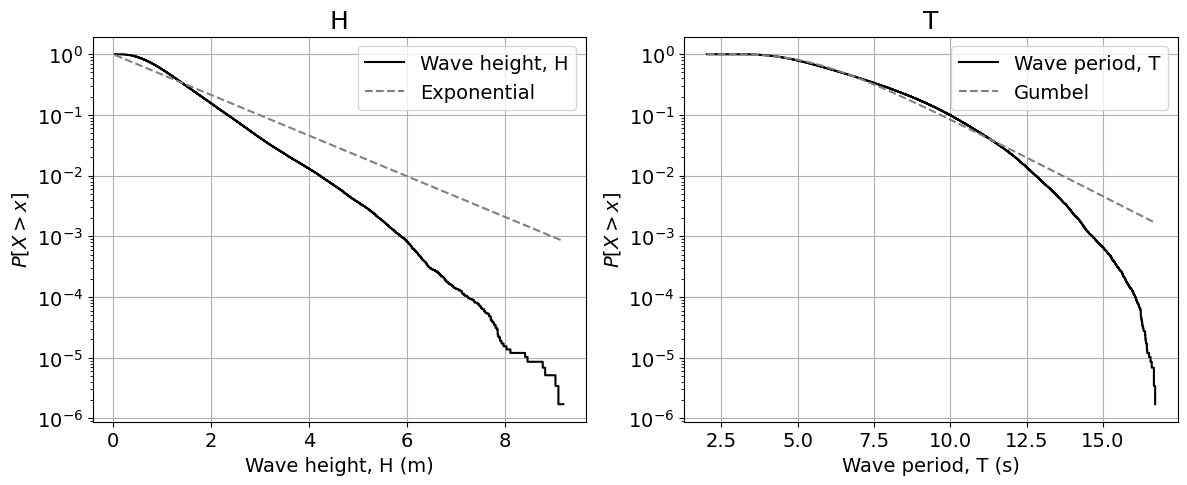

In [54]:
#Graphical method

#Logscale

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].step(ecdf(H)[1], 1-ecdf(H)[0], 
             color='k', label='Wave height, H')
axes[0].plot(ecdf(H)[1], 1-stats.expon.cdf(ecdf(H)[1], *params_H),
             '--', color = 'grey', label='Exponential')
axes[0].set_xlabel('Wave height, H (m)')
axes[0].set_ylabel('${P[X > x]}$')
axes[0].set_title('H', fontsize=18)
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid()

axes[1].step(ecdf(T)[1], 1-ecdf(T)[0], 
             color='k', label='Wave period, T')
axes[1].plot(ecdf(T)[1], 1-stats.gumbel_r.cdf(ecdf(T)[1], *params_T),
             '--', color = 'grey', label='Gumbel')
axes[1].set_xlabel('Wave period, T (s)')
axes[1].set_ylabel('${P[X > x]}$')
axes[1].set_title('T', fontsize=18)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid()

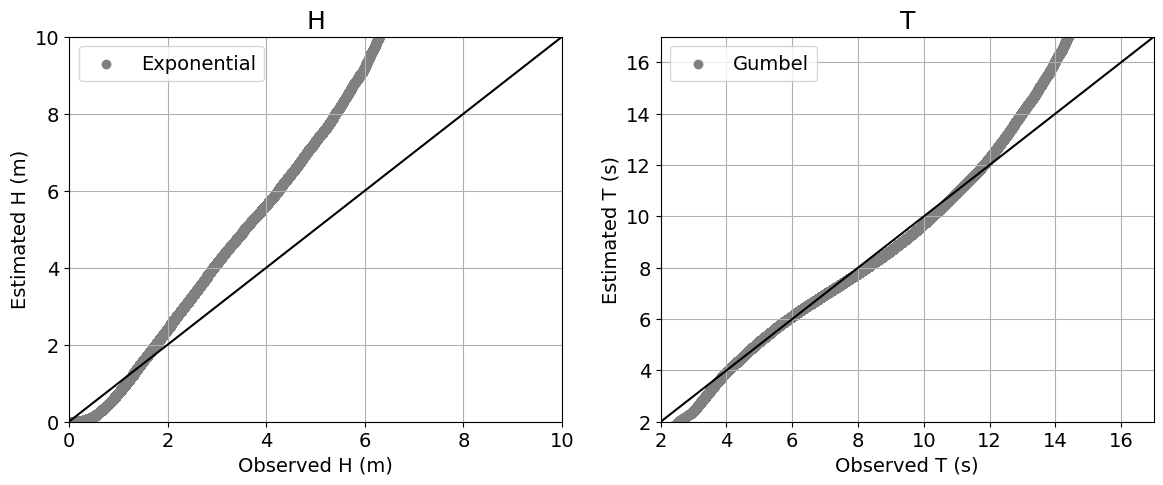

In [55]:
# QQplot

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot([trunc(min(H)), ceil(max(H))], [trunc(min(H)), ceil(max(H))], 'k')
axes[0].scatter(ecdf(H)[1], stats.expon.ppf(ecdf(H)[0], *params_H), 
             color='grey', label='Exponential')
axes[0].set_xlabel('Observed H (m)')
axes[0].set_ylabel('Estimated H (m)')
axes[0].set_title('H', fontsize=18)
axes[0].set_xlim([trunc(min(H)), ceil(max(H))])
axes[0].set_ylim([trunc(min(H)), ceil(max(H))])
axes[0].legend()
axes[0].grid()

axes[1].plot([trunc(min(T)), ceil(max(T))], [trunc(min(T)), ceil(max(T))], 'k')
axes[1].scatter(ecdf(T)[1], stats.gumbel_r.ppf(ecdf(T)[0], *params_T), 
             color='grey', label='Gumbel')
axes[1].set_xlabel('Observed T (s)')
axes[1].set_ylabel('Estimated T (s)')
axes[1].set_title('T', fontsize=18)
axes[1].set_xlim([trunc(min(T)), ceil(max(T))])
axes[1].set_ylim([trunc(min(T)), ceil(max(T))])
axes[1].legend()
axes[1].grid()

In [56]:
#KStest

_, p_H = stats.kstest(H,stats.expon.cdf, args=params_H)
_, p_T = stats.kstest(T,stats.gumbel_r.cdf, args=params_T)

print('The p-value for the fitted Gumbel distribution to H is:', round(p_H, 3))
print('The p-value for the fitted Uniform distribution to d is:', round(p_T, 3))

The p-value for the fitted Gumbel distribution to H is: 0.0
The p-value for the fitted Uniform distribution to d is: 0.0


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6:</b>   
Interpret the results of the GOF techniques. How does the selected parametric distribution perform?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution 6:</b>
    <li> Logscale plot: This technique allows to visually assess the fitting of the parametric distribution to the tail of the empirical distribution. For $H$, Exponential distribution performs well for low values. On the contrary, it does not properly model the right tail. It is on the safe side providing predictions higher than those observed. Note that this may lead to predictions of $H$ that are not physically possible. Regarding $T$, the Gumbel distribution seems to follow the low observations and those around the central moments but not those on the right tail. The predictions provided by the Gumbel distribution are on the safe side. </li>
    <li> QQplot: Similar conclusions to those for Logscale can be derived.</li>
    <li> Kolmogorov-Smirnov test: remember that the null hypothesis of this test is that the samples follow the parametric distribution. Therefore, the p-value represents the probability of the null hypothesis being true. If p-value is lower than the significance ($\alpha=$0.05, for instance), the null hypothesis is rejected. Considering here $\alpha=0.05$, we can reject that the variable $H$ comes from a Exponential distribution and that $T$ comes from a Gumbel distribution.</li>
</div>
</div>

## 5. Propagating the uncertainty

Using the fitted distributions, we are going to propagate the uncertainty from $H$ and $T$ to $F_h$ **assuming that $H$ and $T$ are independent**.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 7:</b>   
    
1. Draw 10,000 random samples from the fitted distribution functions for $H$ and $T$.
    
2. Compute $F_h$ for each pair of samples.
    
3. Compute $F_h$ for the observations.
    
4. Plot the PDF and exceedance curve in logscale of $F_h$ computed using both the simulations and the observations.
</p>
</div>

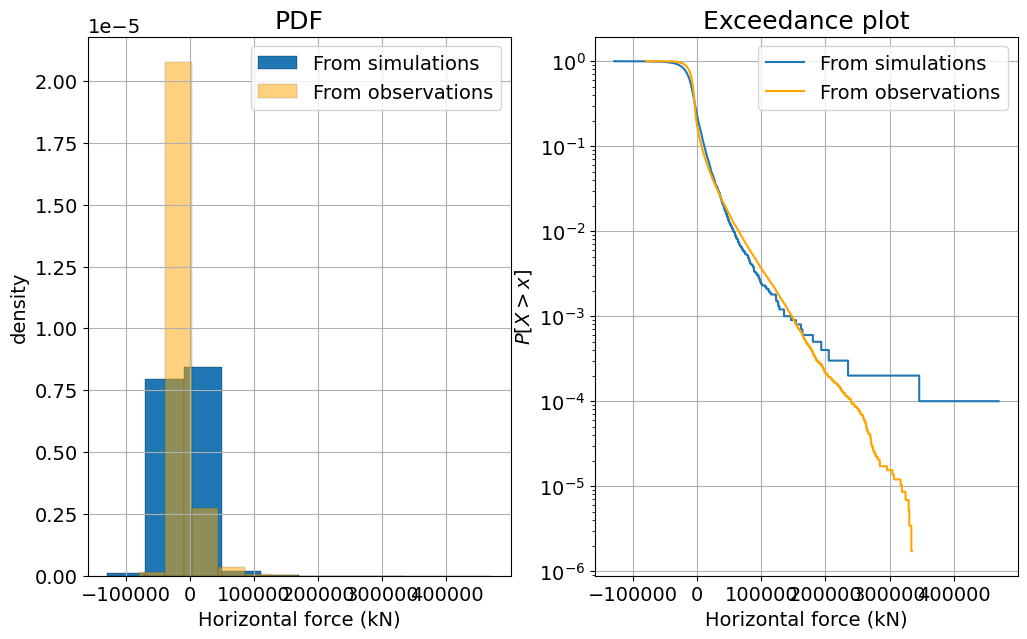

In [58]:
# Here, the solution is shown for the Lognormal distribution

# Draw random samples
rs_H = stats.expon.rvs(*params_H, size = 10000)
rs_T = stats.gumbel_r.rvs(*params_T, size = 10000)

#Compute Fh
rs_Fh = 255.4 * rs_H * rs_T**2 - 490.4*rs_T**2

#repeat for observations
Fh = 255.4 * H * T**2 - 490.4*T**2

#plot the PDF and the CDF
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].hist(rs_Fh, edgecolor='k', linewidth=0.2, density = True, label = 'From simulations')
axes[0].hist(Fh, edgecolor='k', facecolor = 'orange', alpha = 0.5, linewidth=0.2, 
             density = True, label = 'From observations')
axes[0].set_xlabel('Horizontal force (kN)')
axes[0].set_ylabel('density')
axes[0].set_title('PDF', fontsize=18)
axes[0].legend()
axes[0].grid()

axes[1].step(ecdf(rs_Fh)[1], 1-ecdf(rs_Fh)[0], label = 'From simulations')
axes[1].step(ecdf(Fh)[1], 1-ecdf(Fh)[0], color = 'orange', label = 'From observations')
axes[1].set_xlabel('Horizontal force (kN)')
axes[1].set_ylabel('${P[X > x]}$')
axes[1].set_title('Exceedance plot', fontsize=18)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8:</b>   
Interpret the figures above, answering the following questions:
    <li>Are there differences between the two computed distributions for $F_h$?</li>
    <li>What are the advantages and disadvantages of using the simulations?</li>
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution 8:</b>
    <li> In the PDF plot, we can see that the shape of the distribution is similar for $F_h$ although more density around the central moments is concentrated in the simualted data. In the CDF plot, we can see that there are significant differences in the tail of the distribution of $F_h$, being the values from the simulations higher than those computed from the observations. This is because both the Exponential and the Gumbel distribution overpredict the tail of the distributions of $H$ and $T$, respectively. </li>
    <li> <b>Disadvantages:</b> we are assuming that $H$ and $T$ are independent (we will see how to address this issue next week). But is that true? Also, the results are conditioned to how good model is the selected parametric distribution. In this case, since the tail of the distributions of $H$ and $T$ are not properly fitted, the obtained distribution for $F_h$ deviates from the one obtained from the observations. <b>Advantages:</b> I can draw all the samples I want allowing the computation of events I have not observed yet (extreme events).<li> <b>Extra note:</b> The equation you are applying to compute $F_h$ is prepared for extreme waves. Thus, when applied out its range of application, it leads to negative forces which do not have physical meaning.</li>
</div>
</div>

If you run the code in the cell below, you will obtain a scatter plot of both variables. Explore the relationship between both variables and answer the following questions:

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 9:</b>   
    
1. Observe the plot below. What differences do you observe between the generated samples and the observations?
    
2. Compute the correlation between $H$ and $T$ for the samples and for the observartions. Are there differences?
    
3. What can you improve into the previous analysis? Do you have any ideas/suggestions on how to implement those suggestions?
</p>
</div>

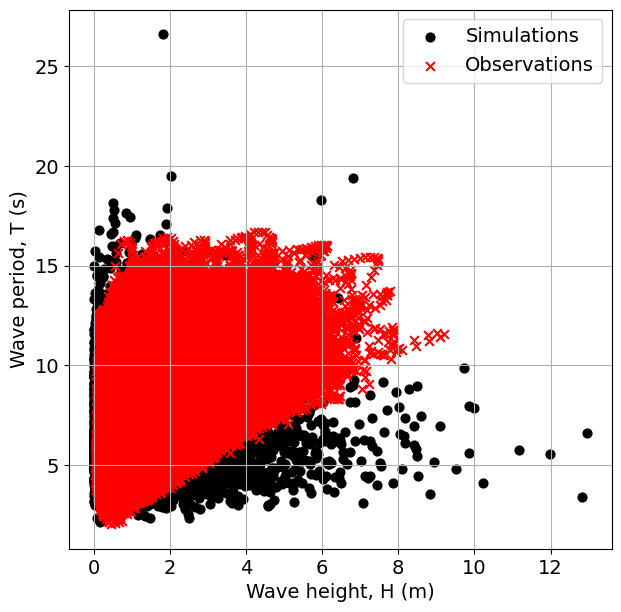

In [59]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
axes.scatter(rs_H, rs_T, 40, 'k', label = 'Simulations')
axes.scatter(H, T, 40, 'r','x', label = 'Observations')
axes.set_xlabel('Wave height, H (m)')
axes.set_ylabel('Wave period, T (s)')
axes.legend()
axes.grid()

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.